# NLP with Disaster Tweets

In [64]:
import pandas as pd                                 # Pandas for DataFrame
from matplotlib import pyplot as plt                # Matplotlib for plots
import spacy                                        # Spacy for text processing
import re                                           # Regex for string extraction
import string                                       # For using string functions and properties

nlp = spacy.load('en_core_web_sm')                  # Load the English language (Options: en_core_web_sm, en_core_web_md, en_core_web_lg)

## Load the data and getting basic idea

In [2]:
# drive_data_root = '/content/drive/MyDrive/Kaggle/NLP-with-Disaster-Tweets/Data/Raw'
local_root = 'Data/Raw'

# Load data from path.
train_df = pd.read_csv(f'{local_root}/train.csv')
test_df = pd.read_csv(f'{local_root}/test.csv')

# Data head
train_df.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


In [3]:
# Data shape
print(f'There are {train_df.shape[0]} rows and {train_df.shape[1]} columns for "train_df".')
print(f'There are {test_df.shape[0]} rows and {test_df.shape[1]} columns for "test_df".')

There are 7613 rows and 5 columns for "train_df".
There are 3263 rows and 4 columns for "test_df".


## Exploratory Data Analysis (EDA)
In this step we explore and investigations the following some of the aspects of our datasets. Namely we examine the following ideas:

- Check the usefulness of 'id' column regarding 'target'.
- Preprocessing steps required for the text.
- Possible Feature Extractions of the text.
- Explore 'location' and 'keyword' columns, find their distributions and relations with the 'target'.

### Target feature
About 57.0% are "0" and around 43.0% are "1". Targets are almost equaly distributed. Since there are only two classes, this is a binary classification problem.

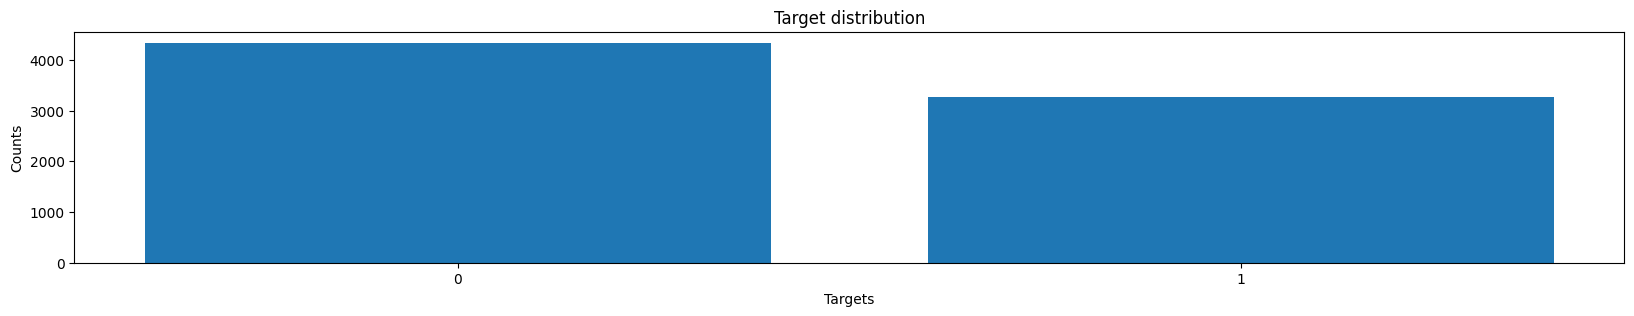

In [4]:
# Check the distribution of tagets
target_counts = train_df['target'].value_counts()

fig = plt.figure(figsize = (20, 3))
plt.title('Target distribution')
plt.xlabel('Targets')
plt.ylabel('Counts')
plt.xticks([0, 1])
plt.bar(target_counts.keys(), target_counts.values)
plt.show()

### Location feature
After careful investigation of the 'location' column, we can take note that:
- Some countries, although the same, have different naming convensions (eg. USA, United states)
- There are some formatting errors (eg. T E X A S)
- 33% of the locations are missing!
- Around 44% of the locations in the dataset are unique. That is a good sign!

- There are 2533 missing entries on "location" column (33.3%)
- Number of unique locations: 3342 (43.9%)


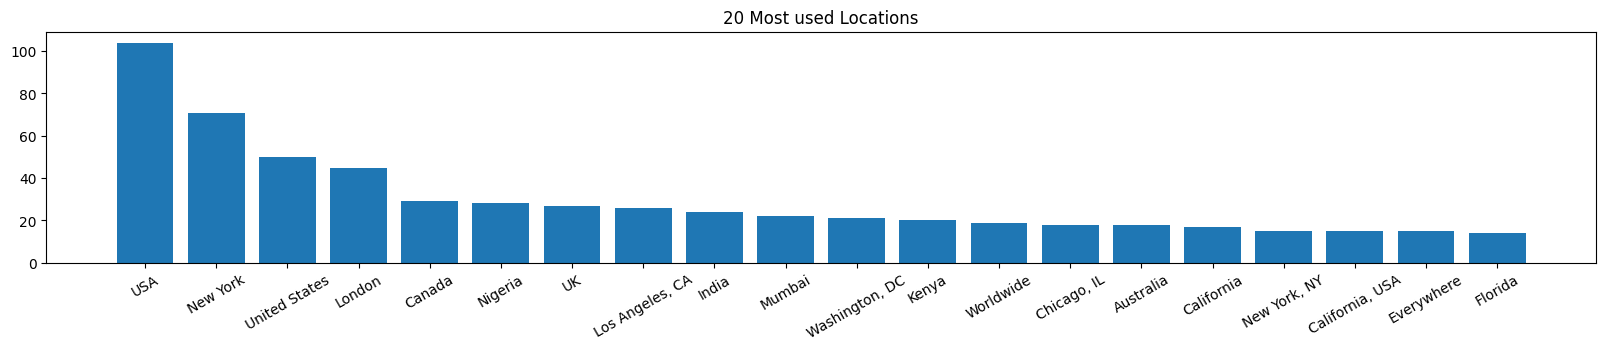

In [5]:
# NULL entries
null_entries = train_df.loc[train_df['location'].isnull()]
null_entries_count = len(null_entries)
print(f'- There are {null_entries_count} missing entries on "location" column ({round(null_entries_count / train_df.shape[0] * 100, 1)}%)')

# Uniqueness
unique_locations = train_df['location'].unique()
unique_locations_count = len(unique_locations)
print(f'- Number of unique locations: {unique_locations_count} ({round(unique_locations_count/train_df.shape[0]*100, 2)}%)')

# 20 Top Frequencies
location_freq = train_df['location'].value_counts()
top_20_locs = location_freq[:20]

fig = plt.figure(figsize = (20, 3))
plt.title('20 Most used Locations')
plt.bar(top_20_locs.index, top_20_locs.values)
plt.xticks(rotation = 30)
plt.show()

### Keyword
We understand the followings from a quick analysis of the keywords:
- Most keywords contain space which is represented by '%20'
- Most keywords indicate distaster signs according to our graph. Good sign here!
- Only about 3% of the keywords are unique. This can be a potencially good feature to base the classification on.

- There are 61 missing entries on "keyword" column (0.8%)
Number of unique keyword: 222 (2.92%)


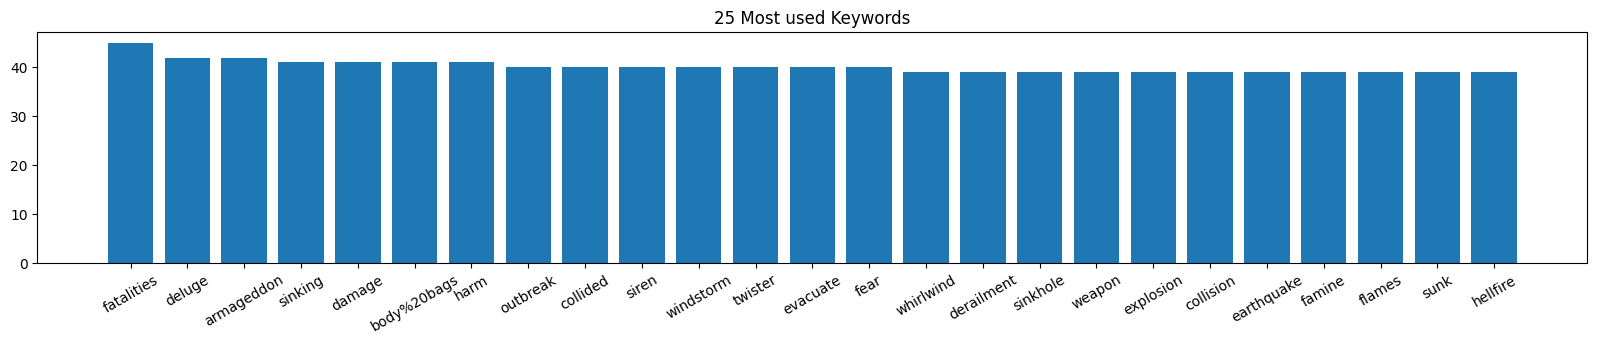

In [6]:
# NULL entries
null_entries = train_df.loc[train_df['keyword'].isnull()]
null_entries_count = len(null_entries)
print(f'- There are {null_entries_count} missing entries on "keyword" column ({round(null_entries_count / train_df.shape[0] * 100, 2)}%)')

# Uniqueness
unique_locations = train_df['keyword'].unique()
unique_locations_count = len(unique_locations)
print(f'Number of unique keyword: {unique_locations_count} ({round(unique_locations_count/train_df.shape[0]*100, 2)}%)')

# 2t Top Frequencies
keyword_freq = train_df['keyword'].value_counts()
keys_25_locs = keyword_freq[:25]

fig = plt.figure(figsize = (20, 3))
plt.title('25 Most used Keywords')
plt.bar(keys_25_locs.index, keys_25_locs.values)
plt.xticks(rotation = 30)
plt.show()

### Text feature
For the sake of educational purposes, I am going to extract as much information as I can from the text, this includes extracting links, hashtags and mentions and
anything that can be considered useful. Some of the task we are going to be doing:
- There are lot's of #hashtags used that can be helpful, so extract the hashtags and store them in a list for each tweet.
- There also are some links, however, since links are shortened (encoded), they are useless in their basic form. We could scrape each link for headlines and titles, but I'm going to remove them for sipmplicity.
- @mentions can be seen in some tweets, maybe they point to a certain user or something, extract the username and store it in a list for each tweet.
- There are some emojies and None-ASCII characters that are better be removed.
- Numbers can also be removed as they may be a little misleading.
- Some comments are written in uppercase, we may want to make them lowercase.
- There are comments that are almost identical except their links, we can easily detect and remove the duplicates after extracting links (See text[110:120])
- With a quick glance of the data, it can be seen that the numebr of words/characters used in each tweet can be very useful as non-disaster tweets are often shorter.
- Maybe finding the common words can be useful for identifing which class does each tweet belong to.

#### Feature Extraction
We extract linkes, hashtags and mentions from the tweet texts and store them in the dataset.

In [45]:
def extract_hashtag(text):
    matches = re.findall(r'#\w*', text)
    return [match[1:].lower() for match in matches] if matches != [] else None

def extract_mention(text):
    matches = re.findall(r'@\w*', text)
    return [match[1:].lower() for match in matches] if matches != [] else None

In [46]:
train_df['hashtags'] = train_df['text'].apply(extract_hashtag)
train_df['mentions'] = train_df['text'].apply(extract_mention)

#### Data Cleaning
To further explore this feature, we must clean the data first by removing irrelevant information such as URLs, mentions, numbers and non-ascii characters.

In [78]:
def clean_data_phase_1(text):

    # 1. Remove all URLs
    text = re.sub(r'\bhttps?://\S+', '', text)

    # 2. Remove all mentions (Mentions are account names which can be meaningless, so it's better to get rid of them)
    text = re.sub(r'@\w*', '', text)
    
    # 3. Remove all numbers
    text = re.sub(r'\d+', '', text)

    # 4. Remove all none-english characters
    text = ''.join(filter(lambda x: x in string.printable, text))

    return text

In [76]:
train_df['cleaned_text_phase_1'] = train_df['text'].apply(clean_data_phase_1)

To even make our future features more robust, we can lemmatize the words, then remove stopwords and punctuations.

In [97]:
def clean_data_phase_2(text):

    doc = nlp(text)

    # 1. Lemmatize words, remove stop words and punctuations
    text = ' '.join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])

    return text

In [101]:
train_df['cleaned_text_phase_2'] = train_df['cleaned_text_phase_1'].apply(clean_data_phase_2)

In [102]:
train_df.head(60)

,id,keyword,location,text,target,hashtags,mentions,cleaned_text_phase_1,cleaned_text_phase_2
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,[earthquake],None,Our Deeds are the Reason of this #earthquake M...,deed Reason earthquake ALLAH forgive
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,None,None,Forest fire near La Ronge Sask. Canada,forest fire near La Ronge Sask Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,None,None,All residents asked to 'shelter in place' are ...,resident ask shelter place notify officer evac...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,[wildfires],None,", people receive #wildfires evacuation orders ...",people receive wildfire evacuation order Calif...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[alaska, wildfires]",None,Just got sent this photo from Ruby #Alaska as ...,got send photo Ruby Alaska smoke wildfires pou...
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1,"[rockyfire, cafire, wildfires]",None,#RockyFire Update => California Hwy. closed i...,RockyFire Update = > California Hwy close di...
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1,"[flood, disaster]",None,#flood #disaster Heavy rain causes flash flood...,flood disaster heavy rain cause flash flooding...
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1,None,None,I'm on top of the hill and I can see a fire in...,hill fire wood
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1,None,None,There's an emergency evacuation happening now ...,emergency evacuation happen building street
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1,None,None,I'm afraid that the tornado is coming to our a...,afraid tornado come area
